# Annual Averaged Hazard Score - Flooding

We first load useful libraries

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as c
import xarray as xr
import rasterio
from wrf import (getvar, interplevel, to_np, latlon_coords, CoordPair, xy_to_ll, ll_to_xy)
from scipy.interpolate import griddata
import geopandas as gp
import warnings
warnings.filterwarnings("ignore")

/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


Then, we load the wind NetCDF file provided with flood depth at a national level. 

In [4]:
dat2 = rasterio.open(r"./DATA/MRe_2y.tif")
dat25 = rasterio.open(r"./DATA/MRe_25y.tif")
dat50 = rasterio.open(r"./DATA/MRe_50y.tif")
dat100 = rasterio.open(r"./DATA/MRe_100y.tif")
dat500 = rasterio.open(r"./DATA/MRe_500y.tif")

z2 = dat2.read()[0]
z25 = dat25.read()[0]
z50 = dat50.read()[0]
z100 = dat100.read()[0]
z500 = dat500.read()[0]

In this case intensities are already assigned in the source file,

In [5]:
x = [2,25,50,100,500]
x = [1/i for i in x]
xprima = [1,2,3,4,5]

pairy = []

A new array will contain the resulting exceedance probabilities

In [6]:
neu = z500

We calculate for each pixel the corresponding exceedance probability at each return period based on the intensity levels. 

In [8]:
for jj in range(0,len(neu)):
    for ii in range(0,len(neu[0])):
        val2=z2[jj][ii]
        val25=z25[jj][ii]
        val50=z50[jj][ii]
        val100=z100[jj][ii]
        val500=z500[jj][ii]
        
        pairy = [val2,val25,val50,val100,val500]

        pairy = [0 if x<0 else x for x in pairy]
        
        yprima = [0.5,0.5,0.5,0.5,0.5]
        
        for kk in range(1,5):
            if kk in pairy: 
                indi = pairy.index(kk)
                yprima[kk]=x[indi]
            else: 
                yprima[kk]=0.5
           
        diff = [x-0.5 for x in yprima]
        
        store=[]
        for cc in range(0,5):
            check = diff[cc]<0
            if check == True: 
                store.append(cc)
            
        if len(store)!=0: 
            for uu in range(store[-1],len(yprima)-1): 
                yprima[uu+1]= 0
        else: 
                yprima=[0,0,0,0,0]

        neu[jj][ii]=np.sum(yprima)
        
neu = np.flipud(neu)    

We now restrict the extension to the Natanebi river basin boundaries

In [9]:
loni = np.linspace(dat2.bounds.left, dat2.bounds.right,len(neu[0]))
lati = np.linspace(dat2.bounds.bottom, dat2.bounds.top,len(neu))
lons, lats = np.meshgrid(loni,lati)

And we plot the AAHS from our calculation method

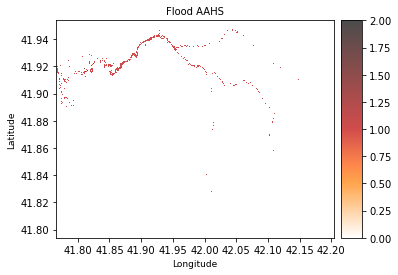

In [11]:
fig, ax = plt.subplots(1,1)
ax.set_title('Flood AAHS', fontsize=10,linespacing=4.2)
ax.set_xlabel('Longitude', fontsize=9,linespacing=4.2)
ax.set_ylabel('Latitude', fontsize=9)
cmap = plt.get_cmap('gist_heat_r')
mesh = ax.pcolormesh(lons,lats,neu,vmin=0, vmax=2,alpha=0.7, cmap=cmap);

plt.colorbar(mesh, ax=ax, shrink=1, pad=.02, aspect=10)
plt.show()